In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import nu, fu
from numpy import nan
from pandas import DataFrame, read_csv, read_excel, concat, get_dummies, isna
from re import split, search, sub, MULTILINE
from scipy.stats import f_oneway, ttest_ind, kruskal, norm
import itertools
import os.path as osp
import re
import statsmodels.api as sm

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(
    verbose=True, metrics_evaluation_open_world_scene_stats_df=''
)
scene_stats_df = data_frames_dict['metrics_evaluation_open_world_scene_stats_df'].copy()
print(sorted([cn for cn in scene_stats_df.columns if 'partici' in cn]))

No pickle exists for metrics_evaluation_open_world_scene_stats_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_scene_stats_df.csv.
['participant_id', 'participation_date']



## Stacked graph for triage errors

In [4]:

# load data frames
data_frames_dict = nu.load_data_frames(
    verbose=True, metrics_evaluation_open_world_csv_stats_df=''
)
csv_stats_df = data_frames_dict['metrics_evaluation_open_world_csv_stats_df'].copy()
print(sorted([cn for cn in csv_stats_df.columns if 'partici' in cn]))

No pickle exists for metrics_evaluation_open_world_csv_stats_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_csv_stats_df.csv.
['participant_id']


In [5]:

# Create the tag-to-SALT data frame
print("\nColumns to merge the scene stats dataset with the CSV stats on:")
on_columns = sorted(set(csv_stats_df.columns).intersection(set(scene_stats_df.columns)))
print(on_columns)


Columns to merge the scene stats dataset with the CSV stats on:
['participant_id', 'scene_id', 'session_uuid']


In [6]:

print('\nThe scene stats dataset columns we want to have in the merge:')
analysis_columns = sorted(set([
    'actual_engagement_distance', 'first_engagement', 'first_treatment', 'injury_correctly_treated_count', 'injury_not_treated_count',
    'injury_treatments_count', 'injury_wrongly_treated_count', 'last_engagement', 'last_still_engagement', 'measure_of_right_ordering',
    'patient_count', 'percent_hemorrhage_controlled', 'pulse_taken_count', 'stills_value', 'teleport_count',
    'time_to_hemorrhage_control_per_patient', 'time_to_last_hemorrhage_controlled', 'total_actions_count', 'triage_time',
    'voice_capture_count', 'walk_command_count', 'walk_value', 'walkers_value', 'wave_command_count', 'wave_value'
]).intersection(set(scene_stats_df.columns)))
print(analysis_columns)

# Merge the scene stats with the CSV stats
survey_columns = ['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'YrsMilExp']
columns_list = on_columns + analysis_columns + survey_columns
assert set(columns_list).issubset(set(scene_stats_df.columns)), "You've lost access to the analysis columns"
merge_df = csv_stats_df.merge(scene_stats_df[columns_list], on=on_columns, how='left').drop_duplicates()


The scene stats dataset columns we want to have in the merge:
['actual_engagement_distance', 'first_engagement', 'first_treatment', 'injury_correctly_treated_count', 'injury_not_treated_count', 'injury_wrongly_treated_count', 'last_engagement', 'last_still_engagement', 'measure_of_right_ordering', 'patient_count', 'percent_hemorrhage_controlled', 'pulse_taken_count', 'stills_value', 'teleport_count', 'time_to_hemorrhage_control_per_patient', 'time_to_last_hemorrhage_controlled', 'total_actions_count', 'triage_time', 'voice_capture_count', 'walk_command_count', 'walk_value', 'walkers_value', 'wave_command_count', 'wave_value']


In [10]:

tag_to_salt_df = fu.get_is_tag_correct_data_frame(merge_df, groupby_column='participant_id')

In [43]:

# Use the patients lists from the March 25th ITM BBAI Exploratory analysis email
desert_patients_list = [
    'Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root'
]
jungle_patients_list = [
    'Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root'
]
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
patients_list = desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list
assert set(patients_list).issubset(
    set(tag_to_salt_df.patient_id)
), f"tag_to_salt_df is missing these patients: {set(patients_list).difference(set(tag_to_salt_df.patient_id))}"
mask_series = tag_to_salt_df.patient_id.isin(patients_list)
tag_to_salt_df = tag_to_salt_df[mask_series]

In [44]:

# Add participant id back in
new_column = 'participant_id'
if (new_column in scene_stats_df.columns) and (new_column not in tag_to_salt_df.columns):
    on_columns = sorted(set(tag_to_salt_df.columns).intersection(set(scene_stats_df.columns)).intersection(set(['scene_id', 'session_uuid'])))
    print(on_columns)
    columns_list = on_columns + [new_column]
    tag_to_salt_df = tag_to_salt_df.merge(scene_stats_df[columns_list], on=on_columns)

In [45]:

import numpy as np

# Compute error_type, removing "Not Tagged" from consideration
def f(df):
    if df.last_tag in fu.error_table_df.index: error_type = fu.error_table_df[fu.error_table_df.index == df.last_tag][df.max_salt].squeeze()
    else: error_type = np.nan
    
    return error_type
groupby_columns = ['last_tag', 'max_salt', 'participant_id']
error_types_df = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame().reset_index(drop=False)
error_types_df['error_type'] = error_types_df.apply(f, axis='columns')

# Convert the columns to the custom categorical type
error_types_df['last_tag'] = error_types_df['last_tag'].astype(fu.colors_category_order)
error_types_df['max_salt'] = error_types_df['max_salt'].astype(fu.salt_category_order)
error_types_df['error_type'] = error_types_df['error_type'].astype(fu.errors_category_order)

# Sort the DataFrame based on the custom categorical orders
error_types_df = error_types_df.sort_values(by=groupby_columns+['error_type'])

In [48]:

mask_series = (error_types_df.patient_count > 0)
error_types_df[mask_series].sort_values('patient_count', ascending=False).head()

,last_tag,max_salt,participant_id,patient_count,error_type
317,red,IMMEDIATE,2024206,4,Exact
319,red,IMMEDIATE,2024208,4,Exact
325,red,IMMEDIATE,2024215,4,Exact
332,red,IMMEDIATE,2024222,3,Exact
318,red,IMMEDIATE,2024207,3,Exact


In [49]:

# Get triage error rates
import re

rows_list = []
for participant_id, responder_categories_df in error_types_df.groupby('participant_id'):
    row_dict = {'participant_id': participant_id}
    df = responder_categories_df.groupby('error_type').patient_count.sum().reset_index(drop=False)
    total_patient_count = df.patient_count.sum()
    error_dict = df.set_index('error_type').patient_count.to_dict()

    over_patient_count = error_dict.get('Over', 0)
    over_triage_error_rate = 100*over_patient_count/total_patient_count
    row_dict['over_triage_error_rate'] = round(over_triage_error_rate, 1)

    under_patient_count = error_dict.get('Under', 0)
    under_triage_error_rate = 100*under_patient_count/total_patient_count
    row_dict['under_triage_error_rate'] = round(under_triage_error_rate, 1)

    critical_patient_count = error_dict.get('Critical', 0)
    critical_triage_error_rate = 100*critical_patient_count/total_patient_count
    row_dict['critical_triage_error_rate'] = round(critical_triage_error_rate, 1)
    
    rows_list.append(row_dict)
triage_error_rates_df = DataFrame(rows_list)

In [50]:

CATEGORY_DICT = {participant_id: participant_id for participant_id in triage_error_rates_df.participant_id}

In [51]:

suffixing_fn = lambda x: f'{x}-triage Error' if (x in ['Over', 'Under']) else (f'{x} Error' if (x in ['Critical']) else x)
def show_stacked_horizontal_bar_chart(rates_df, ylabel=''):
    labels_list = [CATEGORY_DICT[c] for c in FILTERED_CATEGORIES_LIST][::-1]
    over_values, under_values, critical_values = [], [], []
    for column_value in FILTERED_CATEGORIES_LIST[::-1]:
        mask_series = (rates_df.participant_id == column_value)
        over_values.append(rates_df[mask_series].over_triage_error_rate.squeeze())
        under_values.append(rates_df[mask_series].under_triage_error_rate.squeeze())
        critical_values.append(rates_df[mask_series].critical_triage_error_rate.squeeze())
    
    # Create a horizontal bar chart for the first set of values
    over_bar = plt.barh(labels_list, over_values, color='#000000', label=suffixing_fn('Over'))
    
    # Create a stacked horizontal bar chart for the second set of values
    under_bar = plt.barh(labels_list, under_values, color='#717171', label=suffixing_fn('Under'), left=over_values)
    
    # Create a stacked horizontal bar chart for the third set of values
    # The data labels for critical errors should be in white (for better contrast)
    critical_bar = plt.barh(
        labels_list, critical_values, color='#bb0000', label=suffixing_fn('Critical'),
        left=[v1 + v2 for v1, v2 in zip(over_values, under_values)]
    )
    
    # Annotate the values of each value set inside their respective rectangles
    for bars, values in zip([over_bar, under_bar, critical_bar], [over_values, under_values, critical_values]):
        for bar, value in zip(bars, values):
            if (value >= 1): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center',
                color='white', fontsize=6
            )
            elif (value > 0): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height() + 0.06, f'{value:.01f}%', va='center', ha='center',
                color='black', fontsize=6
            )
    
    # Set the title, labels, legend, and grid
    plt.title('Triage Errors')
    plt.xlabel('Percent (%)')
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1.4, 0.62), loc='center right')
    plt.grid(False)
    
    # Display the chart
    plt.show()

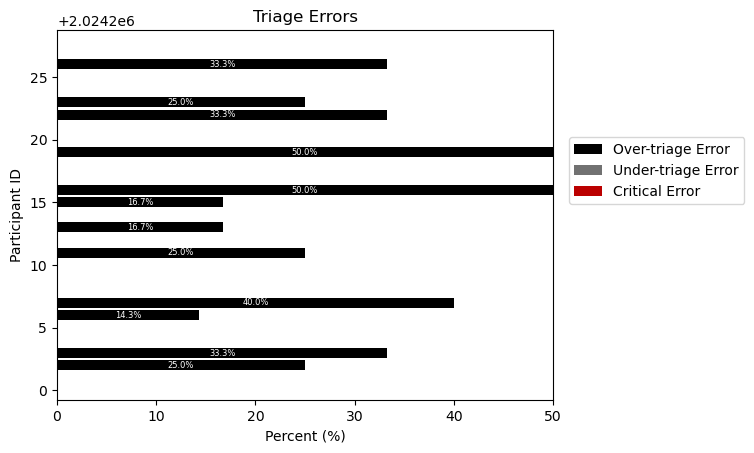

In [52]:

import matplotlib.pyplot as plt

FILTERED_CATEGORIES_LIST = [i for i in range(2024201, 2024228) if i in triage_error_rates_df.participant_id.tolist()]
show_stacked_horizontal_bar_chart(triage_error_rates_df, ylabel='Participant ID')

In [53]:

from datetime import date

today = date.today()
for fn in dir():
    if fn.endswith('_df'):
        nu.save_data_frames(**{f'{today.year}{today.month:02d}{today.day:02d}participant_id_{fn}': eval(fn)}, verbose=True)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_csv_stats_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_dataset_organization_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_error_types_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_merge_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_responder_categories_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_scene_stats_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516participant_id_tag_to_salt_df.csv
Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/20240516particip